Подключение библиотеки

In [1]:
%run libs/pump_unit__2019_02_01__14_23.ipynb

Дополнительные функции

In [2]:
def hist_head(head_outflow, head_inflow):
    head = head_outflow.sub(head_inflow)
    head[head < 0] = 0
    return head

def hist_flow(unit, head, speed, work):
    data = unit.pump.flow(head.values, speed.values)
    series = pd.Series(data, index=head.index)
    series[work < 1] = 0
    return series.fillna(0)

def hist_power_hydro(unit, flow, speed):
    data = unit.pump.power_hydro(flow.values, speed.values)
    series = pd.Series(data, index=flow.index)
    return series.fillna(0)

def hist_power_shaft(unit, flow, speed):
    data = unit.pump.power_shaft(flow.values, speed.values)
    series = pd.Series(data, index=flow.index)
    return series.fillna(0)

def hist_power_electric(unit, power_shaft):
    data = unit.motor.power_electric(power_shaft.values)
    series = pd.Series(data, index=power_shaft.index)
    return series.fillna(0)

def hist_power_supply(unit, power_electric):
    data = unit.vfd.power_supply(power_electric.values)
    series = pd.Series(data, index=power_electric.index)
    return series.fillna(0)

def hist_eff_total(unit, power_hydro, power_supply):
    #isclose = np.isclose(pb.units[0].hist_power_hydro.values, pb.units[0].hist_power_supply.values, rtol=3e-01)
    data = power_hydro.values / power_supply.values * 100.0
    data[data > unit.eff(unit.pump.flow_rated_bep, 1.0)] = 0
    series = pd.Series(data, index=power_hydro.index)
    return series.fillna(0)

# ВНС "Ергенинская"

In [3]:
files = ['data/pump_ergeninskaya.csv',
         'data/pump_ergeninskaya.csv',
         'data/pump_ergeninskaya.csv']

In [4]:
flow_step=1.0
head_step=0.2

In [31]:
!cat data/pump_ergeninskaya.csv

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [5]:
pb = PumpBattery(flow_step, head_step, files)
pb.calc_units_matrices()

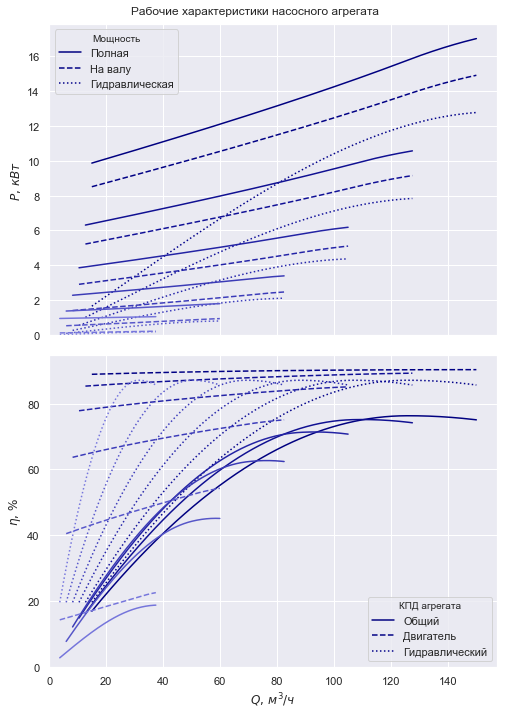

In [6]:
pb.units[0].plot_work_curves()

In [7]:
scenario = 0

pb.calc_mutation_matrix(scenario)

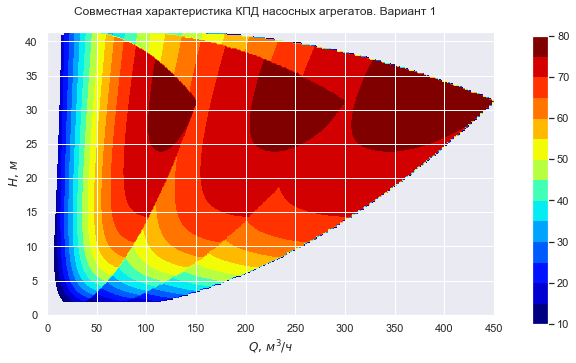

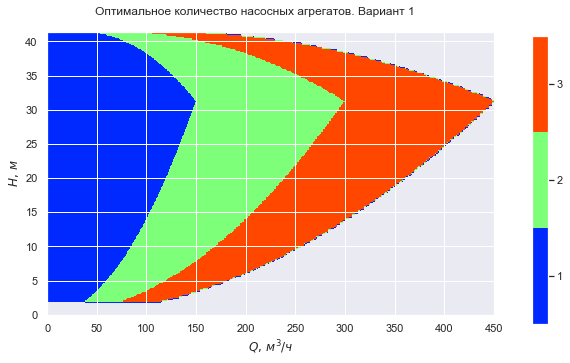

In [8]:
pb.plot_eff_total_map(scenario)
pb.plot_count_total_map(scenario)

## Данные из SCADA

Наличие связи со станцией

In [9]:
pb.historic('link', 'historic/ergeninskaya/link.csv')

По каждому насосу подгружаем историю работы, мощности, частоты

In [10]:
for unit_idx in range(pb.units_num):
    idx = unit_idx + 1
    pb.historic('power_electric', f'historic/ergeninskaya/pu_{idx}/power.csv', unit_idx)
    pb.historic('frequency', f'historic/ergeninskaya/pu_{idx}/frequency.csv', unit_idx)

Подгружаем давление по входному и выходному коллекторам, показания расходомера и электросчетчика

In [11]:
pb.historic('head_inflow', 'historic/ergeninskaya/pressure_in.csv', convert=True)
pb.historic('head_outflow', 'historic/ergeninskaya/pressure_out.csv', convert=True)
pb.historic('flow', 'historic/ergeninskaya/flow.csv')
#pb.historic('power_supply', 'historic/ergeninskaya/power.csv')

Разница высот установки датчиков давления

In [12]:
head_delta = 1.0

### Расчет напора, гидравлической мощности и КПД по данным из SCADA

Расчет напора, создаваемого насосами

In [13]:
pb.hist_head_outflow = pb.hist_head_outflow - head_delta
pb.hist_head = hist_head(pb.hist_head_outflow, pb.hist_head_inflow)

Расчет потребляемой мощности

In [14]:
pb.hist_power_supply = pd.Series(0.0, index=pb.hist_head.index)
for unit in pb.units:
    unit.hist_power_supply = hist_power_supply(unit, unit.hist_power_electric)
    pb.hist_power_supply = pb.hist_power_supply.add(unit.hist_power_supply)

Расчет гидравлической мощности, КПД и удельного потребления ЭЭ

In [15]:
pb.hist_power_hydro = 998.0 * 9.81 * pb.hist_head * pb.hist_flow / 3600.0 / 1000.0
pb.hist_power_rate = (pb.hist_power_supply / pb.hist_flow).replace([np.inf, -np.inf], np.nan).fillna(0)
pb.hist_eff_total = pb.hist_power_hydro / pb.hist_power_supply * 100.0

### Квантование напора и расхода по уровням с заданным шагом

In [16]:
data = [find_index(pb.head_points, x) for x in pb.hist_head.values]
pb.hist_head_idx = pd.Series(data, index=pb.hist_head.index)
pb.hist_head_quant = pd.Series(pb.head_points[data], index=pb.hist_head.index)

data = [find_index(pb.flow_points, x) for x in pb.hist_flow.values]
pb.hist_flow_idx = pd.Series(data, index=pb.hist_flow.index)
pb.hist_flow_quant = pd.Series(pb.flow_points[data], index=pb.hist_flow.index)

### Рекомендуемое количество насосов и наилучшее КПД для рассматриваемых режимов работы станции

In [17]:
size = len(pb.hist_head_idx.values)

data = [pb.count_total_matrix[scenario][pb.hist_head_idx.values[x]][pb.hist_flow_idx.values[x]] for x in range(size)]
pb.hist_work_opt = pd.Series(data, index=pb.hist_head.index)

data = [pb.eff_total_matrix[scenario][pb.hist_head_idx.values[x]][pb.hist_flow_idx.values[x]] for x in range(size)]
pb.hist_eff_total_opt = pd.Series(data, index=pb.hist_head.index)

pb.hist_power_supply_opt = (pb.hist_power_hydro / pb.hist_eff_total_opt * 100).replace([np.inf, -np.inf], np.nan).fillna(0)

### Считаем фактическое и оптимальное количество электроэнергии за период наблюдения

In [18]:
pb.energy = pb.hist_power_supply.sum() / 3600.0
pb.energy_opt = pb.hist_power_supply_opt.sum() / 3600.0

## Графики

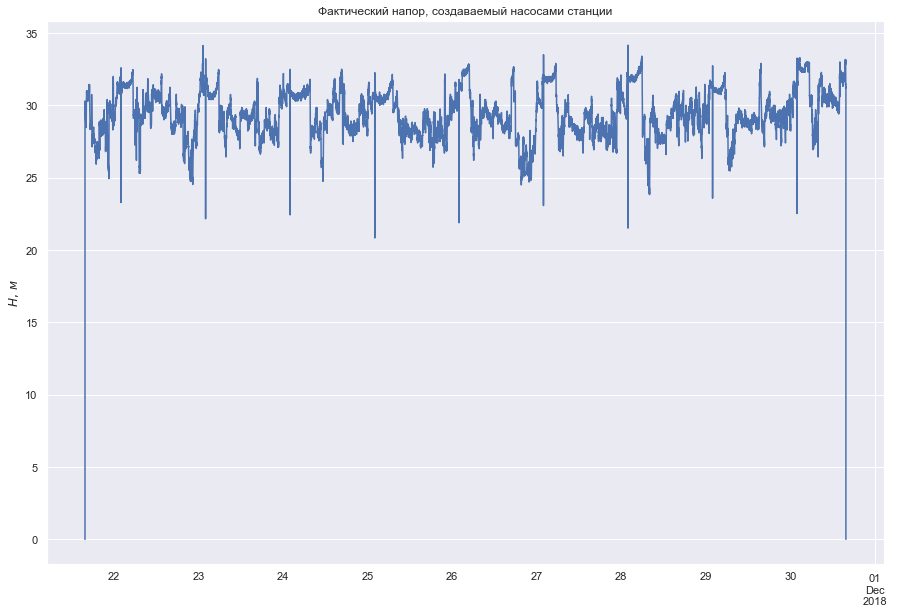

In [19]:
plt.figure(figsize=(15,10))
pb.hist_head.plot()
plt.ylabel('$H,\, м$')
plt.title('Фактический напор, создаваемый насосами станции')
plt.show()

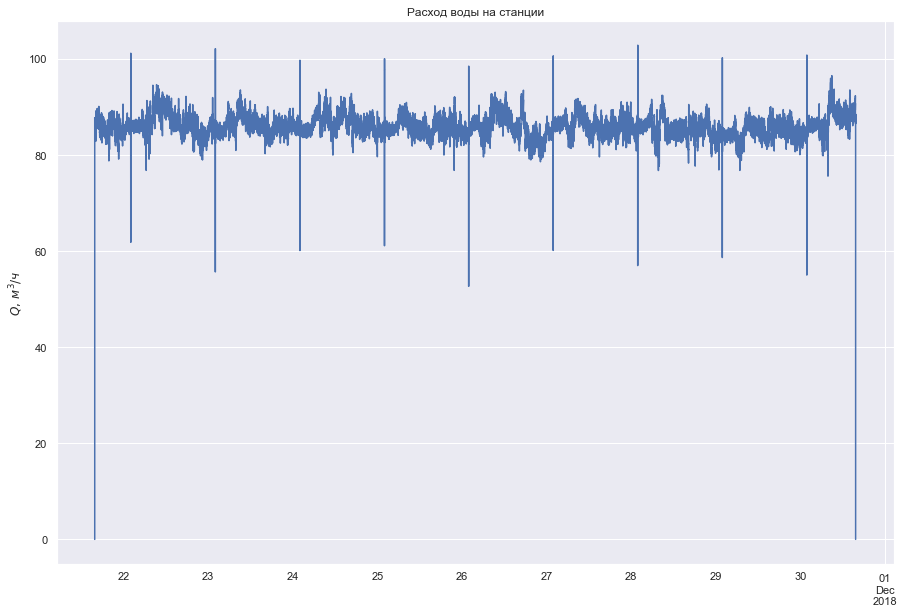

In [20]:
plt.figure(figsize=(15,10))
pb.hist_flow.plot()
plt.ylabel('$Q,\, м^3/ч$')
plt.title('Расход воды на станции')
plt.show()

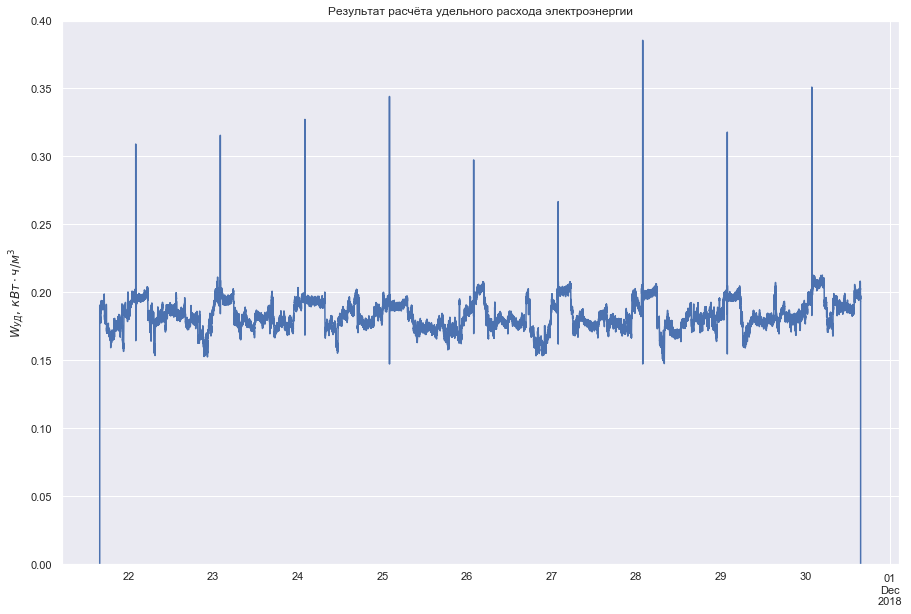

In [21]:
plt.figure(figsize=(15,10))
pb.hist_power_rate.plot()
plt.ylabel('$W_{УД},\, кВт \cdot ч/м^3$')
plt.title('Результат расчёта удельного расхода электроэнергии')
plt.axis([None, None, 0, 0.4])
plt.show()

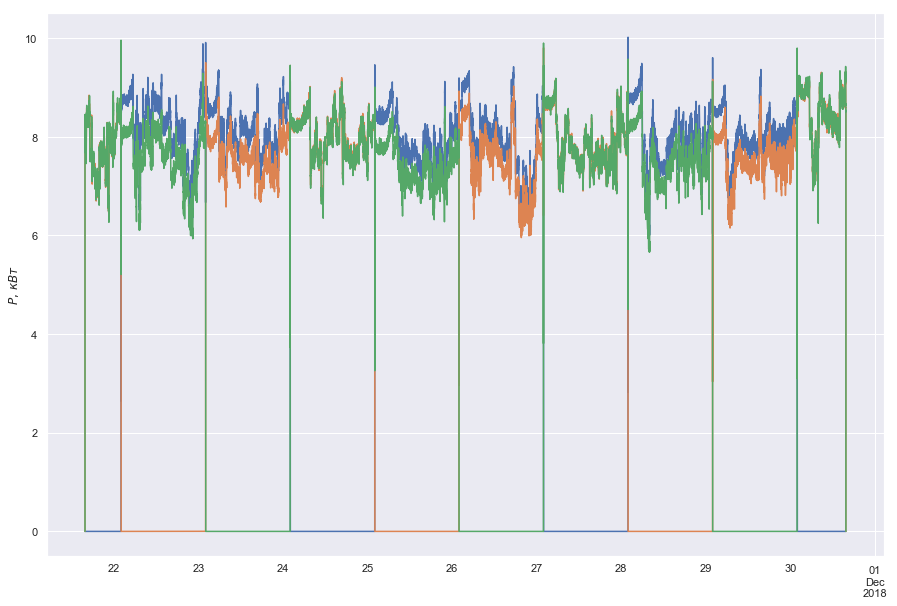

In [22]:
plt.figure(figsize=(15,10))
pb.units[0].hist_power_supply.plot()
pb.units[1].hist_power_supply.plot()
pb.units[2].hist_power_supply.plot()
plt.ylabel('$P,\, кВт$')
#plt.title('Фактический напор, создаваемый насосами станции')
plt.show()

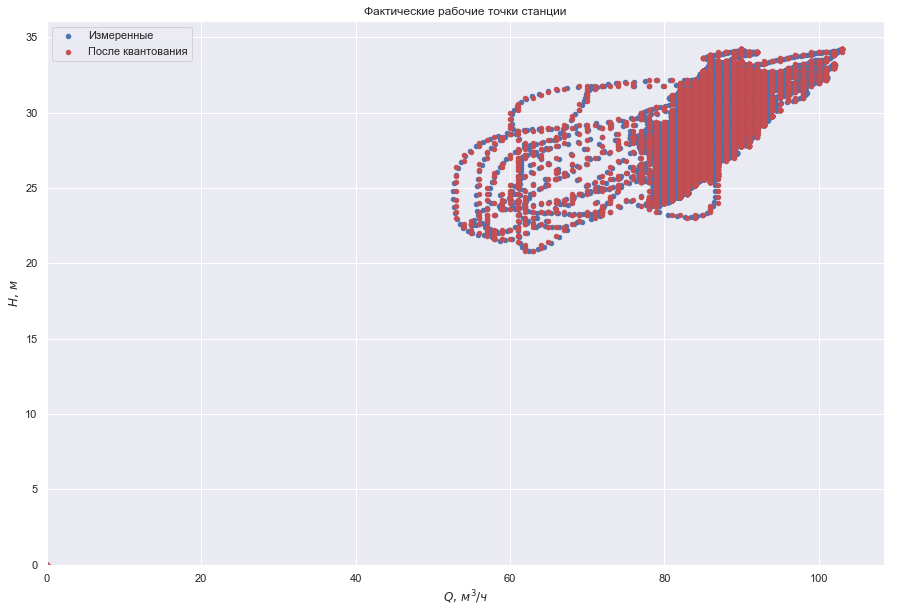

In [23]:
df = pb.hist_head.to_frame(name='head')
df = df.assign(flow=pb.hist_flow)
df = df.assign(head_quant=pb.hist_head_quant)
df = df.assign(flow_quant=pb.hist_flow_quant)
ax = df.plot.scatter(x='flow', y='head', color='b', label='Измеренные', figsize=(15,10))
df.plot.scatter(x='flow_quant', y='head_quant', color='r', label='После квантования', ax=ax)
plt.xlabel('$Q,\, м^3/ч$')
plt.ylabel('$H,\, м$')
plt.title('Фактические рабочие точки станции')
plt.axis([0, None, 0, None])
plt.show()

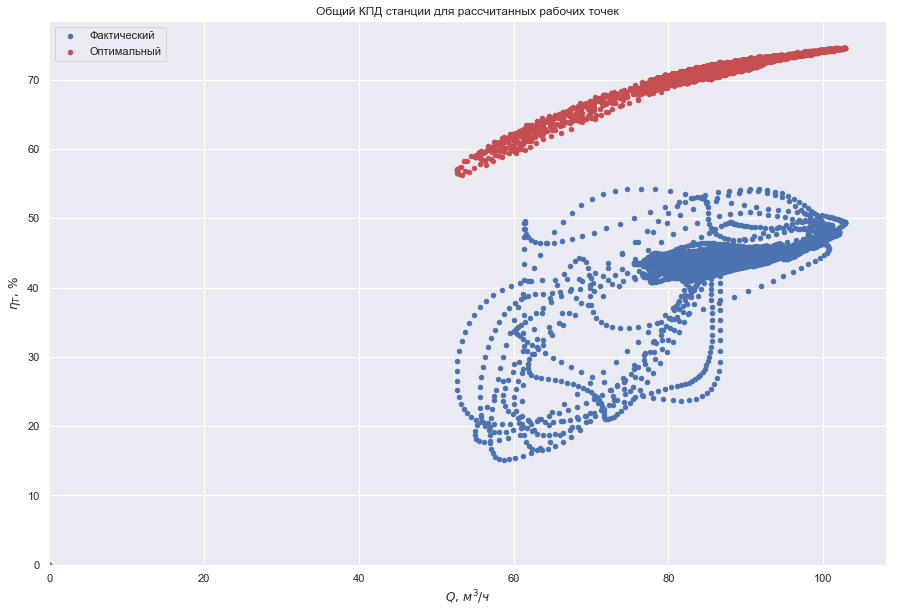

In [24]:
df = pb.hist_eff_total.to_frame(name='eff_total')
df = df.assign(flow=pb.hist_flow)
df = df.assign(eff_total_opt=pb.hist_eff_total_opt)
ax = df.plot.scatter(x='flow', y='eff_total', color='b', label='Фактический', figsize=(15,10))
df.plot.scatter(x='flow', y='eff_total_opt', color='r', label='Оптимальный', ax=ax)
plt.xlabel('$Q,\, м^3/ч$')
plt.ylabel('$\eta_T,\, \%$')
plt.title('Общий КПД станции для рассчитанных рабочих точек')
plt.axis([0, None, 0, None])
plt.legend()
plt.show()

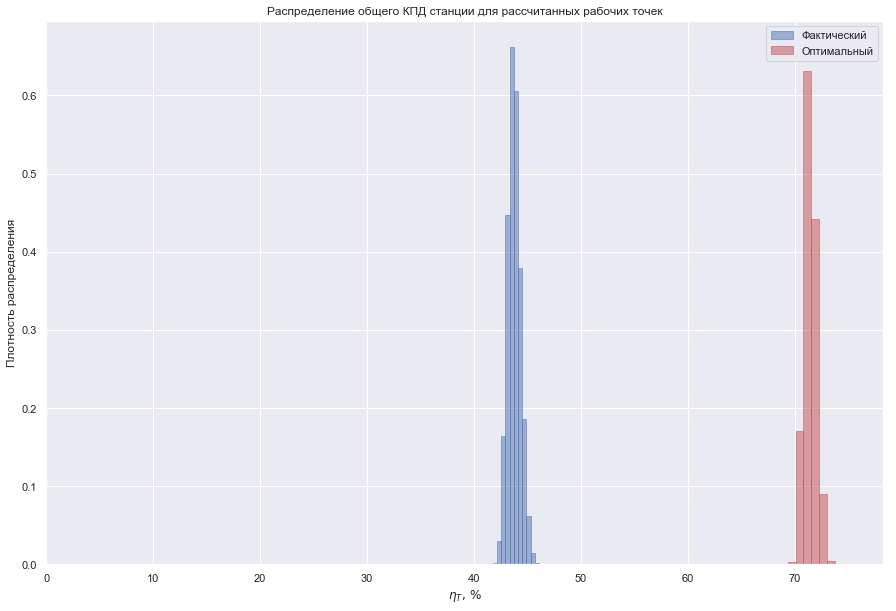

In [25]:
bins = 100
ax = pb.hist_eff_total.plot.hist(bins, density=True, color='b', edgecolor='b', label='Фактический', alpha=0.5, figsize=(15,10))
pb.hist_eff_total_opt.plot.hist(bins, density=True, color='r', edgecolor='r', label='Оптимальный', ax=ax, alpha=0.5)
plt.xlabel('$\eta_T,\, \%$')
plt.ylabel('Плотность распределения')
plt.title('Распределение общего КПД станции для рассчитанных рабочих точек')
plt.axis([0, None, 0, None])
plt.legend()
plt.show()

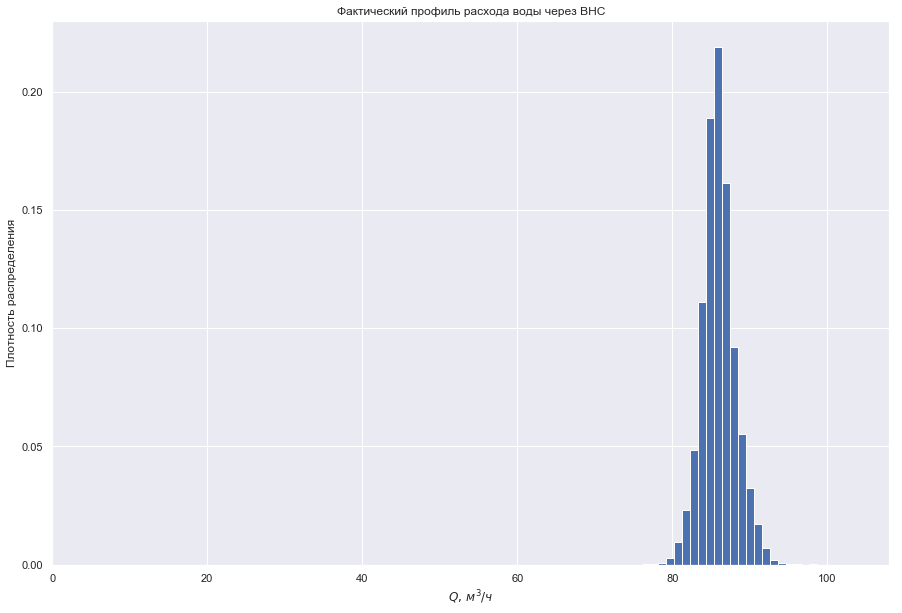

In [26]:
pb.hist_flow.plot.hist(bins, density=True, figsize=(15,10))
plt.ylabel('Плотность распределения')
plt.xlabel('$Q,\, м^3/ч$')
plt.title('Фактический профиль расхода воды через ВНС')
plt.axis([0, None, 0, None])
plt.show()

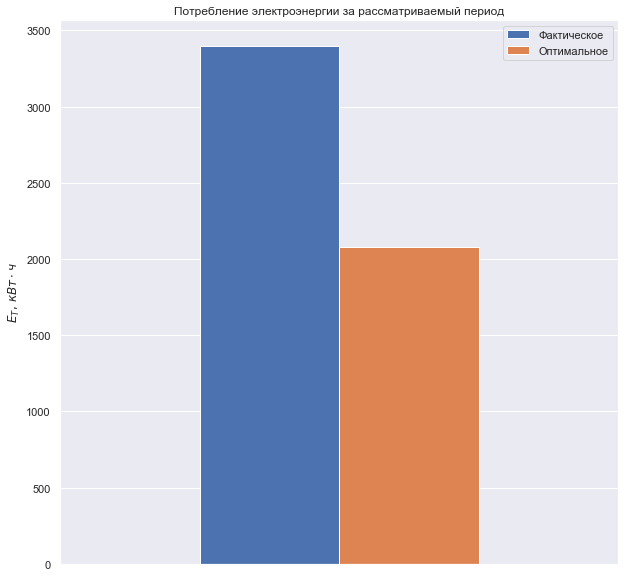

In [27]:
df = pd.DataFrame({'fact': pb.energy, 'opt': pb.energy_opt}, index=[None])
ax = df.plot.bar(rot=0, figsize=(10,10))
ax.legend(["Фактическое", "Оптимальное"])
ax.get_xaxis().set_visible(False)
plt.ylabel('$E_{T},\, кВт \cdot ч$')
plt.title('Потребление электроэнергии за рассматриваемый период')
plt.show()

In [32]:
df.shape

(1, 2)